In [1]:
import numpy as np
pi = np.pi 
import scipy.signal as signal
from scipy.fft import ifft, fft
from scipy.io.wavfile import read
import matplotlib.pyplot as plt

### Part (a)

8kHz divided by 256 yeilds 31.25.  
$\therefore$ for 852Hz and 1477Hz the index should be around $852 // 31.25 = 27$ \& $ 1477 // 31.25 = 47$  
Through inspection of the indices 26, 27 & 28 we get corresponding 812.5, 843.75 & 875 Hz $\rightarrow X_{27}$ will show a peak and consequently for n-k $X_{229}$ will also show a peak.  
Through inspection of the indices 46, 47 & 48 we get corresponding 1437.5 , 1468.75 & 1500Hz $\rightarrow X_{47}$ & $X_{209}$ will show a peak. 

Testing this hypothesis on some pure sine waves.

In [2]:
x = np.sin(2 * pi * np.arange(256) * 852 / 8000)
y = np.abs(fft(x))
y_ = np.abs(np.fft.fft(x))
argmax = np.argwhere(y == np.amax(y)).flatten()
print(argmax, argmax[0]*8000/256)

[ 27 229] 843.75


In [3]:
x = np.sin(2 * pi * np.arange(256) * 1477 / 8000)
y = abs(fft(x))
argmax = np.argwhere(y == np.amax(y)).flatten()
print(argmax, argmax[0]*8000/256)

[ 47 209] 1468.75


## Part (b)

In [4]:
sample_rate, data = read('touchtone.wav')
data = data/2**11
data_len = len(data)

In [5]:
print(f"sample rate: {sample_rate}")

sample rate: 16000


Through examination we can see the closest frequencies are 73 Hz apart. $\therefore$ we do not want $\frac{f_s}{2 \cdot \text{Window size}}$ to be more than 73 Hz and thus have to pick $\frac{16000}{2 \cdot 73} \simeq 110$. Thus, I have chosen 256 as a value that is comfortably above 110 and a power of two and then proceded to increase the power. 

As you can see for 256 & 512 we get very faint output for the lower frequencies. And for 2048 & 4096 separate pulses start to blend in together. Therefore, I have chosen 1024 as the DFT window size.

Below you can see the spectograms produced.

<style type="text/css">
.tg  {border-collapse:collapse;border-spacing:0;}
.tg td{border-color:black;border-style:solid;border-width:1px;font-family:Arial, sans-serif;font-size:14px;
  overflow:hidden;padding:10px 5px;word-break:normal;}
.tg th{border-color:black;border-style:solid;border-width:1px;font-family:Arial, sans-serif;font-size:14px;
  font-weight:normal;overflow:hidden;padding:10px 5px;word-break:normal;}
.tg .tg-0lax{text-align:left;vertical-align:top}
</style>
<table class="tg">
<thead>
  <tr>
      <th class="tg-0lax" colspan="2"><h3><center>Spectograms for different DFT window size</center></h3> </th>
  </tr>
</thead>
<tbody>
    <tr>
    <th class="tg-0lax"><center>256</center></th>
    <th class="tg-0lax"><center>512</center></th>
  </tr>
  <tr>
    <td class="tg-0lax"><img src="256.png"></td>
    <td class="tg-0lax"><img src="512.png"></td>
  </tr>
    
  <tr>
    <td class="tg-0lax" colspan="2"><center>1024</center></td>
  </tr>
  <tr>
    <td class="tg-0lax" colspan="2"><img src='1024.png'></td>
  </tr>
    
  <tr>
    <td class="tg-0lax"><center>2048</center></td>
    <td class="tg-0lax"><center>4096</center></td>
  </tr>
  <tr>
    <td class="tg-0lax"><img src="2048.png"></td>
    <td class="tg-0lax"><img src="4096.png"></td>
  </tr>
    
</tbody>
</table>

In [6]:
# decided after experimentation
block_size = 1024
half_size = block_size // 2

# creating the splits
Xs = np.array([data[i*half_size: (i+2)*half_size] 
               for i in range(len(data)//half_size -1)])

In [7]:
# Using a Hann window for this excersize
window = signal.windows.hann(block_size)
# applying window
X_windowed = np.multiply(Xs, window)

In [8]:
# Performing the FFT on the blocks and taking the absolute values
X_fft = np.abs(fft(X_windowed))

In [9]:
# Plotting the spectogram

def plot_spectogram():
    plt.figure(num=1, figsize=(12,4.5))
    plt.imshow(X = X_fft.transpose(), extent=[0, 4.5, 0, 16000],
               vmin=0, vmax=15, origin='lower', cmap='hot')
    plt.gca().set_aspect(aspect=0.002)
    plt.xlim(0, 4.5)
    plt.ylim(550, 1700)
    plt.xlabel("Time (s)")
    plt.ylabel("Frequency (Hz)")
    plt.hlines(y=[697, 770, 852, 941, 1209, 1336, 1477, 1633], xmin=0, xmax=100, 
                colors="silver", alpha=0.75, linestyle='dashed')
    plt.yticks([697, 770, 852, 941, 1209, 1336, 1477, 1633])

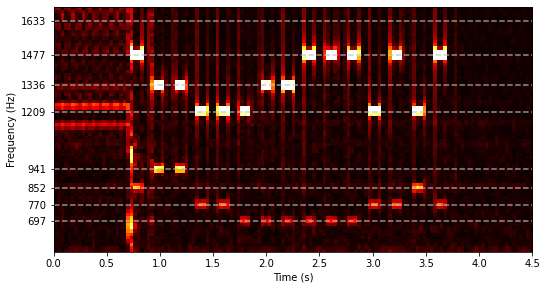

In [10]:
plot_spectogram()

Showing linear magnitude. 
It was possible to show logarithmic magnitude with a different cmap however, they lack the clarity this provides.

The numbers dialed are: 9, 0, 0, 4, 4, 1, 2, 2, 3, 3, 3, 4, 6, 7, 6

## Part (c)

In [11]:
dev = 0.018
freqs = [697, 770, 852, 941, 1209, 1336, 1477]
order = 1501

x_pos = [0.8 + 0.2*a for a in range(15)]

# building the bandpass filter using firwin
filters = [signal.firwin(order, cutoff=[f*(1-dev), f*(1+dev)],fs=16000, pass_zero='bandpass') 
          for f in freqs]

In [12]:
# applying the filter using filtfilt and since it is a FIR filer a=[1.]
X_filtered = [(signal.filtfilt(b, 1., data)) for b in filters]

In order to view the tone I am going to build the spectrogram image of the filtered signals to show clearly when the number is dialed i.e. when the tone is sounded.

In [13]:
# Helper function to build splits
def get_blocks(data, half_size):
    return np.array([data[i*half_size: (i+2)*half_size] for i in range(len(data)//half_size - 1)])

# Helper function to perform the fft, take the absolute value and transpose
def _fft(data):
    return np.abs(fft(data)).transpose()

In [14]:
# Plotting the spectograms

def plot_spectograms():
    fig, axs = plt.subplots(len(freqs), figsize=(6, 10))
    const = 0.02 * freqs[0]* 2 * dev
    
    for i, x in enumerate(X_filtered):
        axs[i].set_title(f"{freqs[i]} \u00B1 1.8% Hz", fontsize=13)
        axs[i].imshow(X=_fft(get_blocks(x, half_size)), extent=[0, 4.5, 0, 16000], 
                      vmin=0, vmax=15, origin='lower', cmap='hot')
        axs[i].set_xlim(0, 4.5)
        fdev=freqs[i]*dev
        axs[i].set_ylim([freqs[i] - fdev, freqs[i] + fdev])
        axs[i].set_yticks([freqs[i] - fdev, freqs[i], freqs[i] + fdev])
        axs[i].set_aspect(aspect=const/(2*fdev))
        axs[i].set_xlabel('Time (s)')
        axs[i].set_ylabel('Freq (Hz)')

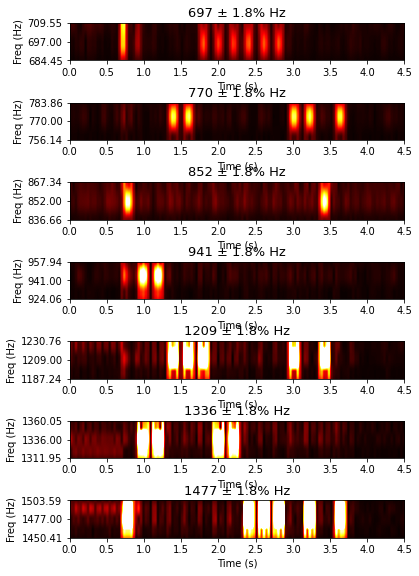

In [15]:
plot_spectograms()

## Part (d)

In [16]:
# Making copies of the signal
shifted_signal = np.array([data for i in range(7)], dtype=complex)

In [17]:
# applying the shift e^(-2j*pi*n*f/fs)
for i, freq in enumerate(freqs):
    shifted_signal[i] = np.multiply(np.exp(-2j*pi*freq/16000 * np.arange(len(data))),
                                    shifted_signal[i])

In [18]:
# fuilding 7 low_pass filters according to freq +/- 1.8 %
low_pass_filters = [signal.firwin(order+1, cutoff=freq*dev*2, fs=16000)
                   for freq in freqs]

# applying the filter
filtered_signal = np.array([
    signal.filtfilt(b=lp_filter, a=1., x=sig) for lp_filter, sig in zip(low_pass_filters, shifted_signal)
])

In [19]:
# Sampling the signal at 100Hz
sampled_signal = np.array([
    sig[0::16000//100] for sig in filtered_signal
])

In [20]:
# Taking the absolute value of the complex values sampled signal
sampled_signal = np.abs(sampled_signal)

In [21]:
# Plotting the resultant waveforms.

def plot_waveform():
    fig, axs = plt.subplots(7, figsize=(9, 27))
    for i, freq in enumerate(freqs):
        axs[i].plot(np.linspace(0, 4.5, sampled_signal.shape[-1]), sampled_signal[i])
        axs[i].set_xlim(0, 4.5)
        temp = sampled_signal[i][50:-50]
        temp = temp[100:] if i==0 else temp
        axs[i].set_ylim(0, np.nanmax(temp))
        axs[i].set_title(f"{freq} \u00B1 1.8 % Hz", fontsize=15)
        axs[i].set_ylabel('')
#         pos = [0.8+a*0.2 for a in range(15)]
        axs[i].set_xticks([0, *x_pos, 4.5])
        axs[i].vlines(x=x_pos, ymin=-0.2, ymax=1, color='gray', linestyle='-.')  

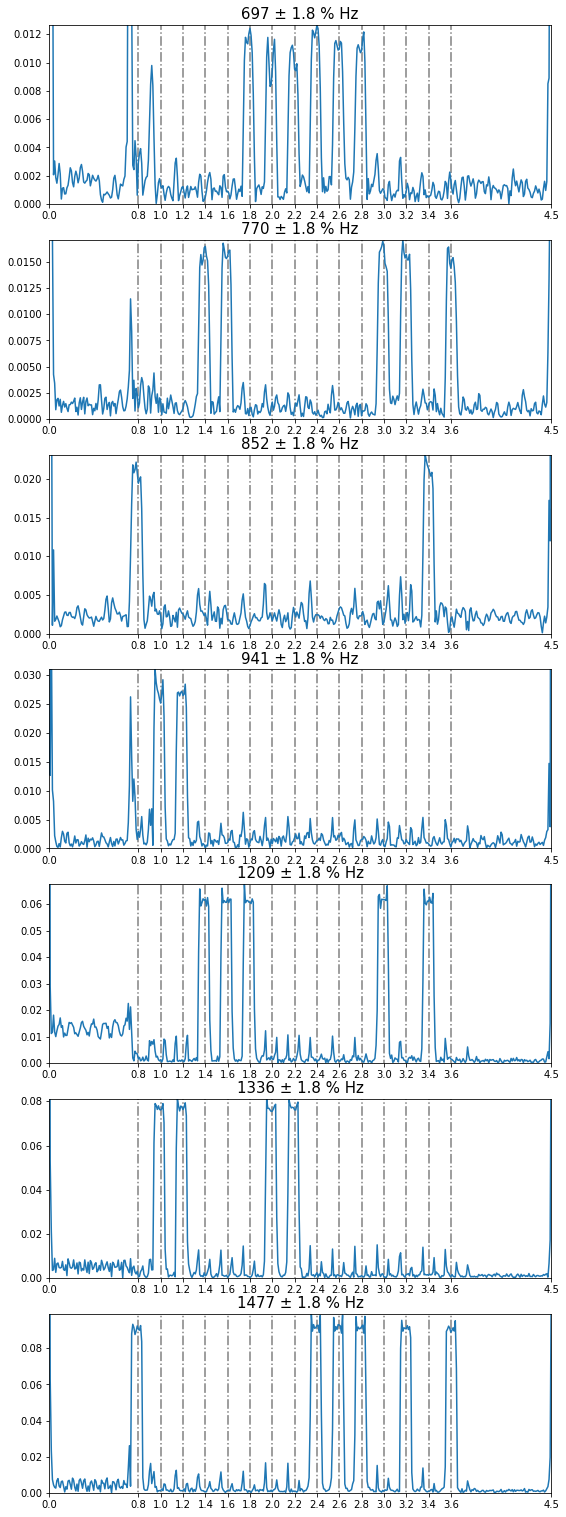

In [22]:
plot_waveform()

Using the vlines plotted for alignment and using the peaks in each graphs: we again get he same numbers dialed -- 9, 0, 0, 4, 4, 1, 2, 2, 3, 3, 3, 4, 6, 7, 6.